In [79]:
using Revise
using Pkg; Pkg.activate(".")
using HypergraphModularityarity

using StatsBase
using Statistics
using Plots
using DataFrames
using SparseArrays
using Clustering

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


In [119]:
# dataset = "HR-congress-bills"
dataset = "SN-congress-bills"
kmax_ = 30

H, Z = read_hypergraph_data(dataset,kmax_)
α = zeros(2*kmax_);

kmax = maximum(keys(H.E))
kmin = minimum(keys(H.E));

H, Z = kcore(H, Z, 0)

n = length(H.D);
D = big(sum(H.D))

158799

## Acquire Warmstart

In [132]:
D = big(sum(H.D))

ωᵢ = 2.0
ωₒ = 0.6
function ω(p, α)
    num = p[1] == 1 ? ωᵢ : ωₒ
    denom = D^sum(p[2])
    return 10000*num / denom
end

Ω̂ = allOrNothingIntensityFunction(ω, maximum(keys(H.E)));

Ẑ_w = SuperNode_PPLouvain(H, Ω̂; α = 0, verbose = false, Z0 = collect(1:n));
Ẑ = zero(Ẑ_w)
println(length(unique(Ẑ_w)))

30


In [133]:
randindex(Ẑ_w, Z)[1]

0.03724516155675963

## Dyadic

In [134]:
function projectedGraph(H)
    
    n = length(H.D)
    A = CliqueExpansion(H, false, false)
    ix, jx, w = findnz(A)
    E = Dict(sort([ix[k], jx[k]]) => w[k] for k in 1:length(ix))

    H̄ = hypergraph(collect(1:n), Dict(1 => Dict(), 2 => E), [0])
    HypergraphModularity.computeDegrees!(H̄);
    return H̄
end

H̄ = projectedGraph(H)

Ω̄ = estimateΩEmpirically(H̄, Ẑ_w; aggregator = p -> [length(p) == 1, sum(p)])

DF = DataFrame()

for i ∈ 1:20
    Ẑ, t = @timed SuperNode_PPLouvain(H̄, Ω̄; α = 0, verbose = false)
    Ω̄ = estimateΩEmpirically(H̄, Ẑ; aggregator = p -> [length(p) == 1, sum(p)])
    
    Q = modularity(H̄, Ẑ, Ω̄; α = 0)
    ℓ = length(unique(Ẑ))
    ARI = randindex(Z, Ẑ)[1]
    
    df = DataFrame(Q = Q, ℓ = ℓ, ARI = ARI, method = "dyadic")
    DF = vcat(DF, df)
    
    println(rpad(round(Q), 15, " "), "    ", rpad(ℓ, 10, " "), "    ", rpad(t, 10, " ") ,"   ", ARI)
end

-7.912814e+06      48            0.201898732   0.056841726918598706
-7.912644e+06      44            0.222353521   0.05676157311629137
-7.912582e+06      45            0.230431061   0.05806295332113014
-7.912561e+06      45            0.199591131   0.05806269086688578
-7.912696e+06      45            0.21165298   0.05935542521930287
-7.942363e+06      47            0.168193364   0.08064906055158552
-7.924891e+06      50            0.222719196   0.06897588457174963
-7.912789e+06      44            0.192464521   0.049631043610984305
-7.912713e+06      48            0.179766646   0.05165783143962546
-7.948181e+06      41            0.225364521   0.011359553698984703
-7.939181e+06      45            0.210848723   0.12813236786667737
-7.917476e+06      54            0.217890637   0.08952545438548894
-7.916708e+06      51            0.224788985   0.08686687957423335
-7.916595e+06      49            0.212883551   0.08539874665940582
-7.913297e+06      51            0.183925153   0.05888735226

# Polyadic AON

In [135]:
Ω̂ = estimateΩEmpirically(H, Ẑ_w; aggregator = p -> [length(p) == 1, sum(p)])

for i ∈ 1:20
    Ẑ, t = @timed SuperNode_PPLouvain(H, Ω̂; α = 0, verbose = false, scan_order = "random")
    Ω̂ = estimateΩEmpirically(H, Ẑ; aggregator = p -> [length(p) == 1, sum(p)])
    
    Q = modularity(H, Ẑ, Ω̂; α = 0)
    ℓ = length(unique(Ẑ))
    ARI = randindex(Z, Ẑ)[1]
    
    df = DataFrame(Q = Q, ℓ = ℓ, ARI = ARI, method = "polyadic AON")
    DF = vcat(DF, df)
    
    println(rpad(round(Q), 15, " "), "    ", rpad(ℓ, 10, " "), "    ", rpad(t, 15, " ") ,"   ", ARI)
end

-1.759268e+06      13            0.857040665       0.02413991552073836
-1.758708e+06      11            0.764868731       0.030676639217728733
-1.758567e+06      11            0.75251292        0.028806643534901748
-1.757853e+06      9             0.744087452       0.033771054245624176
-1.759444e+06      8             0.717139208       0.024510084668818922
-1.757373e+06      10            0.780476364       0.02620303339058387
-1.757251e+06      10            0.762285639       0.019293376277422374
-1.757095e+06      9             0.775307501       0.020032511602051335
-1.763126e+06      11            0.677999384       0.04572655482944875
-1.756549e+06      8             0.762816925       0.028543966070252596
-1.75639e+06       7             0.691625592       0.025375738970727316
-1.756336e+06      7             0.654587315       0.025321319575501974
-1.756332e+06      7             0.650535721       0.022422773889281145
-1.756336e+06      8             0.698855          0.02542267596055

In [113]:
countmap(Ẑ)

Dict{Int64,Int64} with 7 entries:
  7 => 1
  4 => 4
  2 => 41
  3 => 1
  5 => 1
  6 => 115
  1 => 131

In [114]:
using RCall

R"""
library(tidyverse)
"""

RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


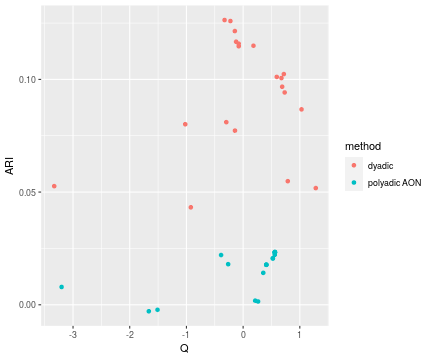

RObject{VecSxp}


In [116]:
R"""
df <- tibble($DF)

df %>% 
    group_by(method) %>% 
    mutate(Q = (Q - mean(Q))/sd(Q)) %>% 
    ggplot() + 
    aes(x = Q, y = ARI, color = method) + 
    geom_point()
"""

# Polyadic General

In [117]:
n_ = big(n)

function ω(p, α)
    k = sum(p)
    return sum(p)/sum((p .* (1:length(p)).^α[k])) / n^(α[kmax+k]*k)
end

function ω_m(p, α)
    k = sum(p)
    kmax = length(α) ÷ 2
    return (2*p[1]/k)^α[k] / n_^(α[kmax+k]*k)
end

Ω̂ = partitionIntensityFunction(ω, kmax);
α̂ = vcat(repeat([10.0], kmax), repeat([2.0], kmax));


# Ω̂ = partitionIntensityFunction(ω_m, kmax);
# α̂ = repeat([2.0], 2*kmax)

α̂ = learnParameters(H, Ẑ_w, Ω̂, α̂; max_iters = 50, verbose = false, tol = 1e-4);
Q = modularity(H, Ẑ_w, Ω̂; α = α̂)

-1.363227138086514475824135876762068263064065126593435870863519781962870772737962e+06

In [118]:
for i ∈ 1:20
    Ẑ, t = @timed SuperNodeLouvain(H, Ω̂; α = α̂, verbose = false, scan_order ="random")
    α̂ = learnParameters(H, Ẑ_w, Ω̂, α̂; max_iters = 10, verbose = false, tol = 1e-4)
    
    Q = modularity(H, Ẑ, Ω̂; α = α̂)
    ℓ = length(unique(Ẑ))
    ARI = randindex(Z, Ẑ)[1]
    
    df = DataFrame(Q = Q, ℓ = ℓ, ARI = ARI, method = "polyadic parameterized")
    DF = vcat(DF, df)
    
    println(rpad(round(Q), 15, " "), "    ", rpad(ℓ, 10, " "), "    ", rpad(t, 15, " ") ,"   ", ARI)
end

InterruptException: InterruptException:

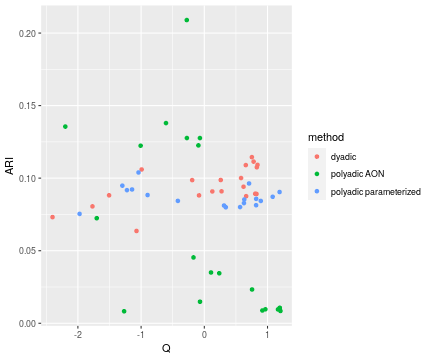

RObject{VecSxp}


In [59]:
R"""
df <- tibble($DF)

df %>% 
    group_by(method) %>% 
    mutate(Q = (Q - mean(Q))/sd(Q)) %>% 
    ggplot() + 
    aes(x = Q, y = ARI, color = method) + 
    geom_point()
"""

In [ ]:
function agg(p)
#     q = minimum(p)
#     k = sum(p)
#     if q >= 2 return [0, k] end
#     return [1, k]
    return [length(p), sum(p)]
end

Ω̂ = estimateΩEmpirically(H, Ẑ_w; aggregator = agg)

for i ∈ 1:20
    Ẑ, t = @timed SuperNodeLouvain(H, Ω̂; α = 0, verbose = false)
    Ω̂ = estimateΩEmpirically(H, Ẑ; aggregator = agg)
    
    Q = modularity(H, Ẑ, Ω̂; α = 0)
    ℓ = length(unique(Ẑ))
    ARI = randindex(Z, Ẑ)[1]
    
    df = DataFrame(Q = Q, ℓ = ℓ, ARI = ARI, method = "polyadic custom")
    DF = vcat(DF, df)
    
    println(rpad(round(Q), 15, " "), "    ", rpad(ℓ, 10, " "), "    ", rpad(t, 15, " ") ,"   ", ARI)
end

### Majorization Penalty

In [397]:
# warmstart
ωᵢ = 2.0
ωₒ = 0.6
function ω(p, α)
    num = p[1] == 1 ? ωᵢ : ωₒ
    denom = big(sum(H_.D))^sum(p[2])
    return 10000*num / denom
end

Ω = allOrNothingIntensityFunction(ω, maximum(keys(H_.E)));

Ẑ, t = @timed SuperNode_PPLouvain(H, Ω; α = 0, verbose = false, Z0 = collect(1:n), clusterpenalty = n)
Ω̂ = estimateΩEmpirically(H, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);
Q = modularity(H, Ẑ, Ω̂; α = nothing) - n*log(length(unique(Z)))
k = length(unique(Ẑ))
println(round(Q - n * log(k)), "    ", k, "    ", t)

-14936.0    6    0.12556582


In [398]:
function ω_m(p, α)
    k = big(sum(p))
    kmax = length(α) ÷ 2
    return (p[1]/k)^α[k] / n^(α[kmax+k]*k)
end

Ω̂ = partitionIntensityFunction(ω_m, kmax);
α̂ = vcat(repeat([10.0], kmax), repeat([1.0], kmax));

In [399]:
for i ∈ 1:5
    α̂ = learnParameters(H, Ẑ, Ω̂, α̂; max_iters = 50, verbose = false) 
    Ẑ, t = @timed SuperNodeLouvain(H,kmax,Ω̂;α=α̂, verbose=false, scan_order ="random");
    Q = modularity(H, Ẑ, Ω̂; α = α̂)
    k = length(unique(Ẑ))
    
    NMI = mutualInformation(Z, Ẑ, true)
    println(round(Q), "    ", k, "    ", rpad(t, 10, " ") ,"   ", NMI)
end

InterruptException: InterruptException:

# Ground Truth

In [416]:
α̂ = learnParameters(H, Z, Ω̂, α̂; max_iters = 1000, verbose = false) 
Q = modularity(H, Z, Ω̂; α = α̂)

-14653.99064269901118557493380289218514767396291651551455769549583275286063969922